# CS6475: Image Frequency Spectra
---
This notebook follows the lectures in Module 4 dealing with frequency domain transforms of images. In many cases (as in the Blending project) there are clear analogues between operations in the frequency and spatial domains, but operating in the frequency domain also affords some unique opportunities. The walkthrough portion illustrates some practical issues that arise out of convention or implementation choices in the Numpy fft module, then proceeds to produce frequency spectra from images. 

You should complete Parts 1-3 by reading through the notebook and executing each code cell (you can use the keyboard shortcut `shift + enter` to execute cells). The last last section of the notebook contains a series of challenge problems that ask you to apply & extend these concepts. There are no required deliverables for this exercise, but you are encouraged to complete & discuss the material & challenge problems on the course forum. This material may appear on the final exam.

## Lesson Summary
---
  - [Part 1 - Fourier Transform Basics](#Part-1:-Fourier-Transform-Basics) -- demonstrate the basics of Fourier transforms
  - [Part 2 - Real Image Spectra](#Part-2:-Real-Image-Spectra) -- visualize images as functions
  - [Part 3 - Challenges](#Part-3:-Challenges) -- apply what you've learned


In [1]:
%matplotlib inline

In [2]:
import cv2

import numpy as np
import numpy.fft as fft
import matplotlib as mpl

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML

mpl.rcParams['image.cmap'] = "gray"  # show images as grayscale by default

## Part 1: Fourier Transform Basics

First, there are some mathematical details & conventions of the Fourier transform to review. We'll be using simple 1-D signals as examples, then extending these concepts to images. We will use the numpy `numpy.fft` module, which implements both the forward & inverse Fourier transform.

**Key Concepts:**
- Discrete Fourier Transform: frequencies & "standard order"
- Plotting complex numbers: magnitude & power spectrum

### 1.1 Plotting a 1-D signal

The first example will use a simple sine wave, which we will represent as a collection of (x, y) pairs corresponding to discrete samples of the signal.

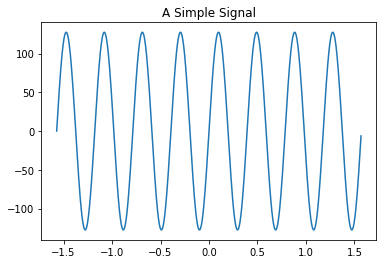

In [3]:
# Define amplitude, mean, frequency, and phase of a 1-D sine wave for testing
number_of_points = N = 1024  # number of samples
dc_signal = 0.  # mean value of the signal
amplitude = 127.5  # height of the wave
frequency = 16.  # width of the wave
phase = 0  # shift the wave

x = np.linspace(-np.pi/2, np.pi/2, number_of_points + 1)[:-1]
y = dc_signal + amplitude * np.sin(frequency * x + phase)  # Generate a simple sine wave

plt.plot(x, y); plt.title("A Simple Signal");

### 1.2 Plotting the DFT

For discrete signals, we use the [Discrete Fourier Transform [DFT]](https://en.wikipedia.org/wiki/Discrete_Fourier_transform) (which is analogous to the Fourier Transform used on continuous signals). 

Since a single sine wave has only one frequency component, the DFT should only have one amplitude corresponding to the frequency of the sine wave. (It will also have one component corresponding to the average value of the signal if it is non-zero). Recall that the frequency components are represented with complex numbers, where the real parts correspond to the amplitude of **cosine** wave components of the signal, and the imaginary parts correspond to the amplitude of **sine** wave components.

Since our input is a pure sine wave, we expect the real part of the amplitude to be zero. (Try experimenting with different phase offset, frequency, amplitude, and dc_signal values to see how they affect the DFT.)

Also note that while we said there should only be _one_ frequency component from our input signal, there are two peaks for each frequency in the output. That's because each pair of peaks represent the same frequency as a result of symmetry; the imaginary part will always be flipped over the x axis (because sin(x) = -sin(-x)) and the real part will always be mirrored across the y axis (because cos(x) = cos(-x)). As a result, the DFT of a signal or image contains half as many frequencies as there are cycles in the signal; the highest frequency term in the DFT is known as the [Nyquist frequency](https://en.wikipedia.org/wiki/Nyquist_frequency).

You can experiment with the parameters of the signal to explore the effects on the DFT. The code below also contains an example for animating the graph in the notebook; you can modify it to animate the results of changing any of the parameters.

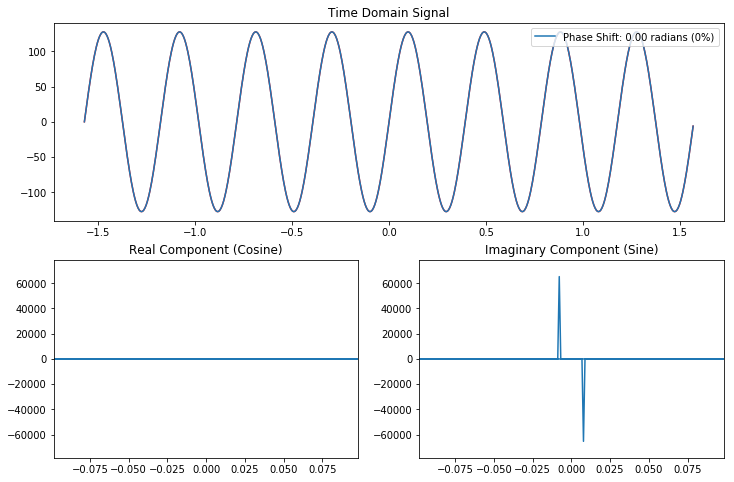

In [4]:
number_of_points = N = 1024  # number of samples
dc_signal = 0.  # mean value of the signal
amplitude = 127.5  # height of the wave
frequency = 16.  # width of the wave
phase = 0  # shift the wave
x = np.linspace(-np.pi/2, np.pi/2, number_of_points + 1)[:-1]
frequencies = fft.fftfreq(N)

# set up figure & axis handles
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot(2, 1, 1)
ax2 = plt.subplot(2, 2, 3)
ax3 = plt.subplot(2, 2, 4)

original_y = dc_signal + amplitude * np.sin(frequency * x + phase)
delta_phase = 2 * np.pi / N  # step size for animating phase shift
def update(frame):
    _phase = delta_phase * frame
    y = dc_signal + amplitude * np.sin(frequency * x + phase + _phase)  # Generate a simple sine wave
    Y = fft.fft(y)
    x_max = np.pi / 32.  # 1/32 is an arbitrary scale factor for the x axis
    y_max = 1.2 * np.max(np.abs(Y))  # 1.2 is an arbitrary scale factor for the y axis
    
    ax1.clear(); ax2.clear(); ax3.clear();
    ax1.plot(x, original_y, c='r');
    ax1.plot(x, y, label="Phase Shift: {:.2f} radians ({:.0f}%)".format(_phase, 100 * _phase / (2 * np.pi)));
    ax1.set_title("Time Domain Signal"); ax1.legend(loc='upper right');
    ax2.plot(frequencies, Y.real);
    ax2.set_xlim(-x_max, x_max); ax2.set_ylim(-y_max, y_max);
    ax2.set_title("Real Component (Cosine)")
    ax3.plot(frequencies, Y.imag);
    ax3.set_xlim(-x_max, x_max); ax3.set_ylim(-y_max, y_max);
    ax3.set_title("Imaginary Component (Sine)")
    return [ax1, ax2, ax3]

update(0);

# Uncomment this section to animate phase shifting the signal from 0...2π - this may take several minutes
# frames = np.arange(N)
# h = FuncAnimation(fig, update, frames=frames[::4], interval=30);
# plt.close()
# HTML(h.to_html5_video())

### 1.3 Plotting 1-D FFT Magnitude

The amplitude of each frequency is spread over the real & imaginary components depending on the phase of the signal, but the magnitude of each frequency component does **not** vary with the phase. So one conventional simplification in viewing frequency spectra is to simply plot the magnitude of each frequency rather than plotting the real and imaginary components separately. The symmetry of the real and imaginary components appears in the magnitude plot as well, so it is common to plot only one half (typically the positive frequencies) of the signal.

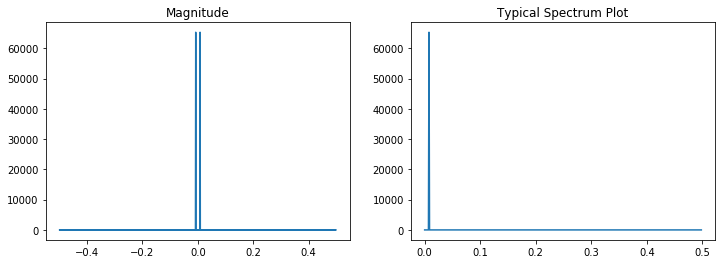

In [5]:
y = dc_signal + amplitude * np.sin(frequency * x + phase)  # Generate a simple sine wave
Y = fft.fft(y)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(frequencies, np.abs(Y)); ax1.set_title('Magnitude');
ax2.plot(frequencies[:(N - 1) // 2], np.abs(Y[:(N - 1) // 2])); ax2.set_title('Typical Spectrum Plot');

### 1.4 Plotting 1-D Energy Spectrum Density

The magnitude of each frequency component can span different orders of magnitude, so it is also common to visualize the frequency spectrum through the Power or Energy Spectrum Density, which uses a logarithmic scale. (It's not very interesting for the 1d signal, but a useful exercise before visualizing images in 2D.)

_Technically_ the energy is given by the formula:

$$ESD = 10 * Log_{10}(|Y|^2)$$

But if you're only displaying the spectrum then you can drop the constants (they all get washed out when the imshow() function normalizes the output range). The two plots below just differ by a scale factor on the y-axis.

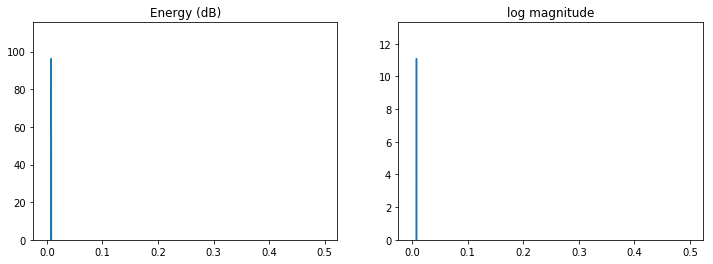

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
midpoint = (N - 1) // 2
esd = 10 * np.log10(np.abs(Y[:midpoint])**2)
esd_alt = np.log(np.abs(Y[:midpoint]))
ax[0].plot(frequencies[:midpoint], esd); ax[0].set_ylim(0, 1.2 * np.max(esd)); ax[0].set_title('Energy (dB)');
ax[1].plot(frequencies[:midpoint], esd_alt); ax[1].set_ylim(0, 1.2 * np.max(esd_alt)); ax[1].set_title('log magnitude');

### 1.5 DFT "Standard" Order

All of the previous examples plotted the amplitudes on the y-axis against the frequencies given by the `fft.fftfreq()` function. The DFT actually stores the frequency components in so-called ["standard order"]() with the DC component (the average value of the signal) at index 0, followed by terms from the positive roots of unity, then the terms from the negative roots of unity. (The positive and negative roots of unity correspond to partial rotations around the complex unit circle -- but you can skip the math and just use the DFT as long as you know that it returns things in an unexpected order.)

```
[a_0, a_1, ..., a_n/2, a_n/2+1, ..., a_n-1]
  ^    ^_________^      ^_____________^
  |         |                  |
  |         |                  |-- decreasing negative roots of unity
  |         |-- increasing positive roots of unity
  |-- DC component
```

If you plot the signal in standard order instead of mapped to `fft.fftfreq()` values then the symmetric peaks correspond from the edges towards the middle rather than from the middle out towards the edges.

The array can be re-organized to put the components in order of the frequencies using the `fft.fftshift` function. That puts the dc component in the middle with increasing frequencies to the right and decreasing frequencies to the left. (There is no practical reason to prefer fftshift for 1-D signals, but it _does_ slightly simplify plotting for 2-D signal spectra.)

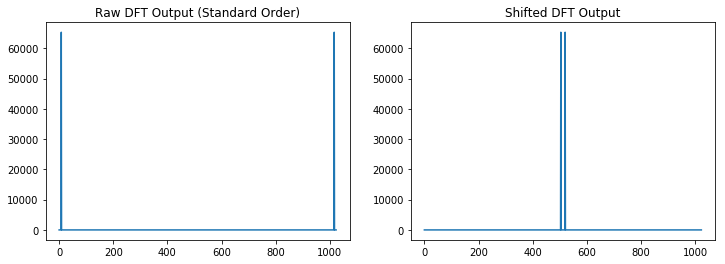

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(np.abs(Y)); ax[0].set_xlim(-50, N + 50); ax[0].set_title('Raw DFT Output (Standard Order)');
ax[1].plot(np.abs(fft.fftshift(Y))); ax[1].set_xlim(-50, N + 50); ax[1].set_title('Shifted DFT Output');

### 1.6 Scale Factor

The last minor issue to note is that there is a scale factor in the DFT. By symmetry of the fourier transform we can perform the inverse fourier transform by calculating the DFT of the complex conjugate of the image frequency spectra and correcting the scale.

Conventionally, the scale factor is handled during the inverse DFT -- and that's exactly what `fft.ifft` does. But it's an arbitrary choice -- you could just as easily handle it during the forward DFT or split the scale difference between the forward and inverse FFT. It's only worth noting because it's the reason that you may notice amplitudes seen in the DFT output are all increased by a constant scale factor. (It especially doesn't matter much when we're plotting image frequency spectra because the spectra image will be normalized to the display range anyway which will cancel out the scale factor.)

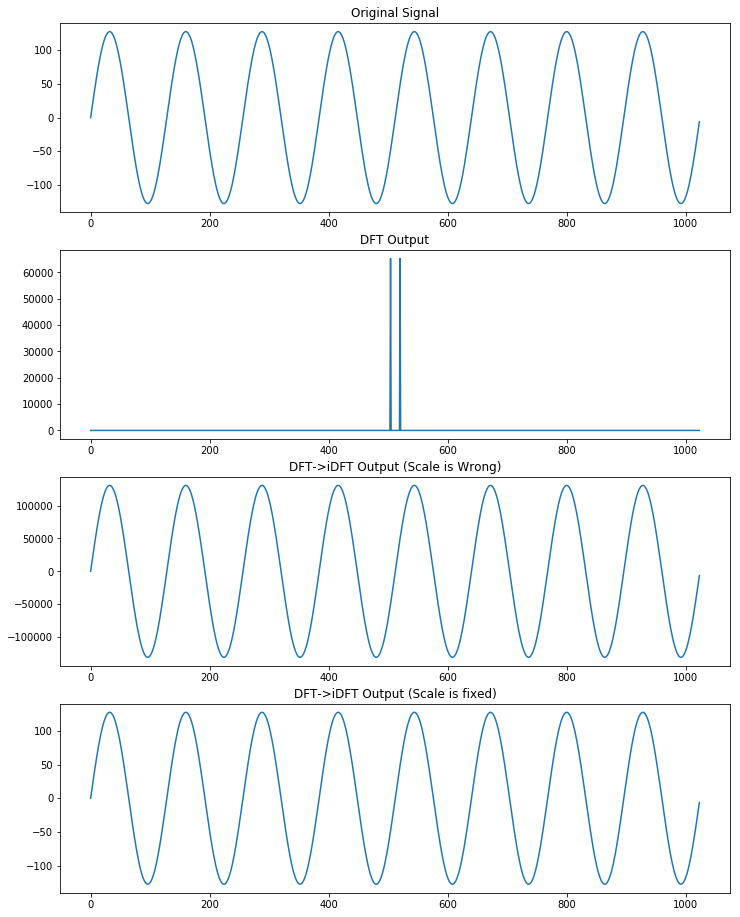

In [8]:
y = dc_signal + amplitude * np.sin(frequency * x + phase)  # Generate a simple sine wave
Y = fft.fft(y)
mag = np.abs(fft.fftshift(Y))
_y = fft.fft(Y.conjugate()).real
_y_scaled = fft.fft(Y.conjugate()).real / N

fig, ax = plt.subplots(4, 1, figsize=(12, 16))
ax[0].plot(y); ax[0].set_title('Original Signal');
ax[1].plot(mag); ax[1].set_title('DFT Output');
ax[2].plot(_y); ax[2].set_title('DFT->iDFT Output (Scale is Wrong)');
ax[3].plot(_y_scaled); ax[3].set_title('DFT->iDFT Output (Scale is fixed)');

### 1.7 Extending to 2D (from Module 04-01)

Everything so far applies to 2-D signals, and -- more conveniently -- it also "just works" in 2-D. We don't have to introduce any new math or conventions to apply the forward and inverse fft in 2-D.

The next cell shows an image similar to one of the examples in lecture and the associated frequency spectrum obtained from `fft.fft2()`. (It doesn't look _exactly_ like the spectrum in lecture because there are several subtle differences -- including numpy/pyplot vs. matlab.)

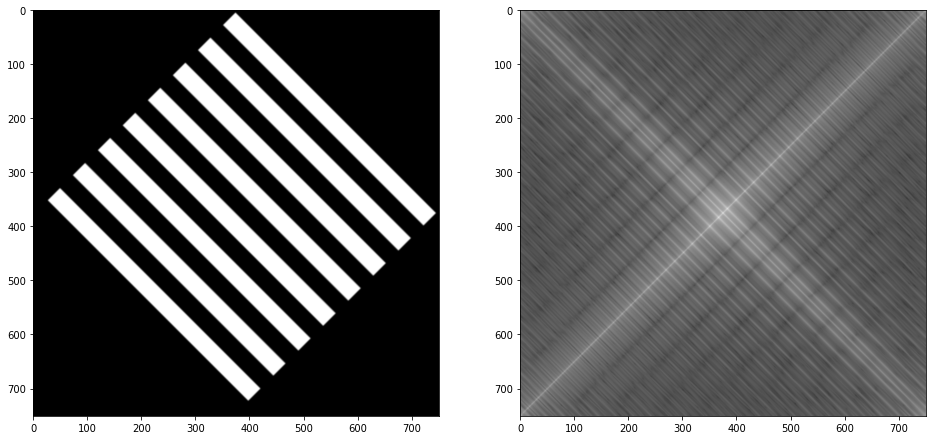

In [9]:
img = cv2.imread('bars.png', cv2.IMREAD_GRAYSCALE)
Img = fft.fft2(img)
mag = np.abs(fft.fftshift(Img))
plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.imshow(img, interpolation="bicubic")
plt.subplot(1,2, 2)
plt.imshow(np.log10(mag), interpolation="bicubic");

### 1.8 1-D vs 2-D DFT

The 2-D DFT is actually equivalent to performing the 1-D DFT sequentially along the two axes of the image -- it doesn't matter which order they're applied. (Compare the result of `fft2` above with the combined row/col DFT below computed using only the 1-D DFT.)

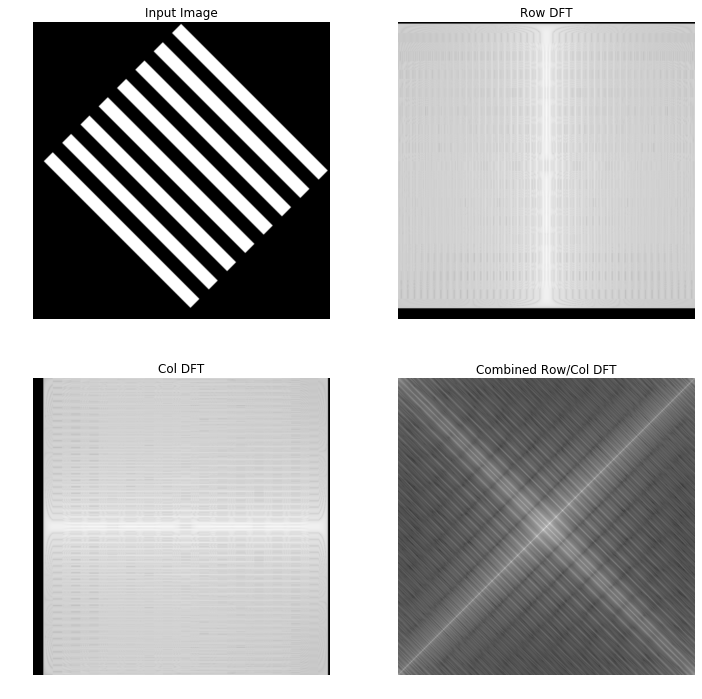

In [10]:
img = cv2.imread('bars.png', cv2.IMREAD_GRAYSCALE)
col_fft = fft.fft(img, axis=0)
row_fft = fft.fft(img, axis=1)
cr_fft = fft.fft(fft.fft(img, axis=1), axis=0)
# fftshift works on both 1d & 2d, so it must be applied to each slice independently
col_mag = np.abs(np.apply_along_axis(fft.fftshift, 0, col_fft))
row_mag = np.abs(np.apply_along_axis(fft.fftshift, 1, row_fft))
cr_mag = np.abs(fft.fftshift(cr_fft))

f, ax = plt.subplots(2, 2, figsize=(12,12))
ax[0, 0].imshow(img, interpolation='bilinear'); ax[0, 0].axis("off"); ax[0, 0].set_title("Input Image");
ax[0, 1].imshow(np.log(row_mag + 1e-10), interpolation='bilinear'); ax[0, 1].axis("off"); ax[0, 1].set_title("Row DFT");
ax[1, 0].imshow(np.log(col_mag + 1e-10), interpolation='bilinear'); ax[1, 0].axis("off"); ax[1, 0].set_title("Col DFT");
ax[1, 1].imshow(np.log(cr_mag + 1e-10), interpolation="bilinear"); ax[1, 1].axis("off"); ax[1, 1].set_title("Combined Row/Col DFT");

### 1.9 Recovering the Signal from the Frequency Spectrum

The inverse Fourier transform (`np.ifft`) is used to recover the original signal from the frequency spectrum. For discrete, real signals (like images) there is an exact correspondance between the terms in the fft and the pixel values in the image. Calling the inverse transform on the frequency spectrum will exactly recover the original image:

  - `np.ifft2(np.fft(img)) == img`

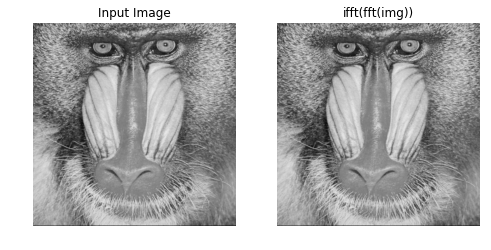

In [11]:
# demonstrate the identity: np.ifft2(np.fft2(x)) == img
img = cv2.imread('baboon.png', cv2.IMREAD_GRAYSCALE)
fft_ifft_img = np.abs(fft.ifft2(fft.fft2(img)))
f, ax = plt.subplots(1, 2, figsize=(8,6))
ax[0].imshow(img, interpolation='bilinear'); ax[0].axis("off"); ax[0].set_title("Input Image");
ax[1].imshow(fft_ifft_img, interpolation='bilinear'); ax[1].axis("off"); ax[1].set_title("ifft(fft(img))");

Additionally, it turns out that the inverse transform uses the same process as the forward transform. As a result, there is a symmetrical relationship between the two operations:

  - `np.ifft2(np.fft2(x)) == np.fft2(np.ifft2(x)) == img`

  - `np.fft2(np.fft2(x)) / k == np.ifft2(np.ifft2(x)) * k == flipped(img)`
  
The input image is "flipped" in the second identity, but the DC terms (the first in each row/column) are not flipped like the others; this has to do with the order of the roots of unity in calculating the fft vs the ifft. (See the `fftflip` function for details on correcting the resulting term order.)

img == ifft(fft(img)):  True
img == fft(ifft(img)):  True
fft(ifft(img)) == ifft(fft(img)):  True


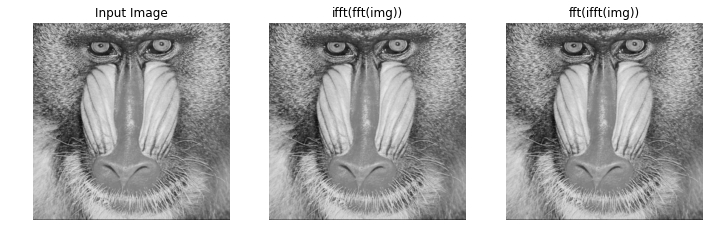

In [12]:
# demonstrate the identity: np.ifft2(np.fft2(x)) == np.fft2(np.ifft2(x)) == img
img = cv2.imread('baboon.png', cv2.IMREAD_GRAYSCALE)
fft_ifft_img = np.abs(fft.ifft2(fft.fft2(img)))
ifft_fft_img = np.abs(fft.fft2(fft.ifft2(img)))

print("img == ifft(fft(img)): ", np.allclose(img, fft_ifft_img))
print("img == fft(ifft(img)): ", np.allclose(img, ifft_fft_img))
print("fft(ifft(img)) == ifft(fft(img)): ", np.allclose(ifft_fft_img, fft_ifft_img))

f, ax = plt.subplots(1, 3, figsize=(12,6))
ax[0].imshow(img, interpolation='bilinear'); ax[0].axis("off"); ax[0].set_title("Input Image");
ax[1].imshow(fft_ifft_img, interpolation='bilinear'); ax[1].axis("off"); ax[1].set_title("ifft(fft(img))");
ax[2].imshow(ifft_fft_img, interpolation='bilinear'); ax[2].axis("off"); ax[2].set_title("fft(ifft(img))");

flip(img) == fft(fft(img)) / k:  True
flip(img) == ifft(ifft(img) * k:  True
fft(fft(img)) / k == ifft(ifft(img)) * k:  True


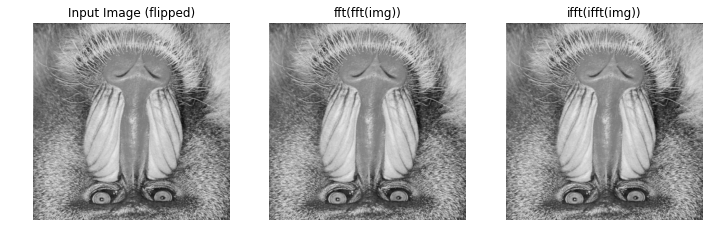

In [13]:
# demonstrate the identity: np.fft2(np.fft2(x)) / k == np.ifft2(np.ifft2(x)) * k == flipped(img)

def fftflip(img):
    """Correct the order of terms after applying fft or ifft twice. The DC term is *NOT*
    flipped, so the order can be fixed by flipping all columns except the first, then
    all rows except the first.
    """
    img[1:, :] = img[1:, :][::-1, :]
    img[:, 1:] = img[:, 1:][:, ::-1]
    return img

img = cv2.imread('baboon.png', cv2.IMREAD_GRAYSCALE)
k = np.product(img.shape)
fft_img = np.abs(fft.fft2(fft.fft2(img)) / k)
ifft_img = np.abs(fft.ifft2(fft.ifft2(img)) * k)

_img = fftflip(img)
print("flip(img) == fft(fft(img)) / k: ", np.allclose(_img, fft_img))
print("flip(img) == ifft(ifft(img) * k: ", np.allclose(_img, ifft_img))
print("fft(fft(img)) / k == ifft(ifft(img)) * k: ", np.allclose(fft_img, ifft_img))

f, ax = plt.subplots(1, 3, figsize=(12,6))
ax[0].imshow(_img, interpolation='bilinear'); ax[0].axis("off"); ax[0].set_title("Input Image (flipped)");
ax[1].imshow(fft_img, interpolation='bilinear'); ax[1].axis("off"); ax[1].set_title("fft(fft(img))");
ax[2].imshow(ifft_img, interpolation='bilinear'); ax[2].axis("off"); ax[2].set_title("ifft(ifft(img))");

## Part 2: Real Image Spectra

### 2.1 Visualizing the signal

Applying the Fourier transform to real images assumes that we can treat images as a 2-d signal where the x and y spatial dimensions are analogous to the role usually played by time, and that pixel intensity is the amplitude of the signal. The next cell illustrates the "signal" corresponding to a single arbitrary row in a real image. Since the 2-D DFT is just taking the DFT of each row & column, these signals are exactly what the DFT will encode in the spectrum.

<div align="middle">
<video width="720" height="480" src="baboon.mp4" controls loop>
</video></div>

In [14]:
# This code was used to generate the previous clip

# real_img = cv2.imread('baboon.png', cv2.IMREAD_GRAYSCALE)
# f, ax = plt.subplots(figsize=(10,6), subplot_kw={"projection": '3d'});
# xx, yy = np.meshgrid(np.arange(real_img.shape[0]), np.arange(real_img.shape[1]))
# ax.plot_surface(xx, yy, real_img[::-1], cmap='gray', shade=True);
# ax.plot(xx[300, :], yy[300, :], real_img[212, :], color="blue")
# ax.set_xticks([]);
# ax.set_yticks([]);
# ax.set_zticks([]);
# ax.view_init(90, -90)
# steps = 60
# az1 = np.linspace(-90, 90, steps)
# az2 = np.linspace(-90, -270, steps)
# az2[az2 < -180] += 360
# el = np.linspace(90, 0, steps)
# pause_count = 30
# k = 0
#
# def update(i):
#     global k
#     if pause_count <= i < steps + pause_count:
#         ax.view_init(el[k], az1[k])
#         k += 1
#     elif steps + 2 * pause_count <= i:
#         k -= 1
#         ax.view_init(el[k], az2[k])
#     return ax
#
# h = FuncAnimation(f, update, frames=range(2 * (steps + pause_count)), interval=50);
# plt.close()
# HTML(h.to_html5_video())

### 2.2 Spectra of Real Images

Real images produce more complex frequency spectra. Repeated patterns in the image appear as lines in the frequency spectrum.

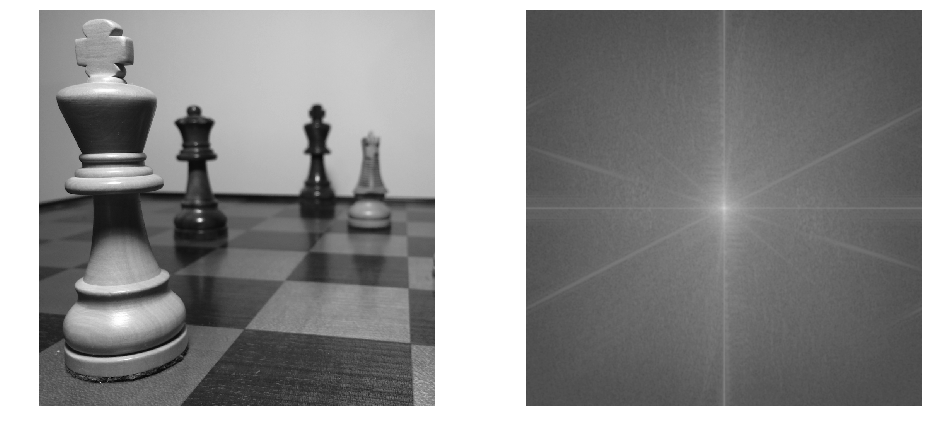

In [15]:
real_img = cv2.imread('test.png', cv2.IMREAD_GRAYSCALE).astype(float)
Img = fft.fft2(real_img)
mag = np.abs(fft.fftshift(Img))

plt.figure(figsize=(16, 16))
plt.subplot(2,2,1)
plt.imshow(real_img); plt.axis('off');
plt.subplot(2,2,2)
plt.imshow(np.log(mag), interpolation='bicubic'); plt.axis('off');

### 2.3 Attenuating the Borders

It's very common in real images to see two bright lines (one vertical & one horizontal) passing through the center of the spectrum. These lines appear because the DFT implicitly assumes that the input image is a finite sample from an infinite repeated signal (i.e., it acts as though the input image is tiled repeatedly in every direction). You can verify that by attenuating the pixel intensity near the borders to zero, which forces the signal to become periodic.

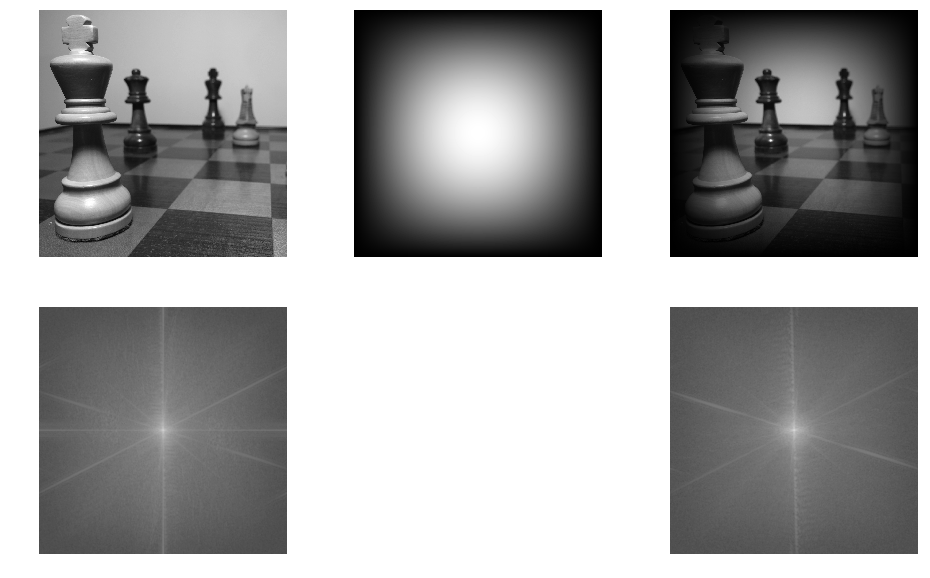

In [16]:
real_img = cv2.imread('test.png', cv2.IMREAD_GRAYSCALE)
Img = fft.fft2(real_img)
mag = np.abs(fft.fftshift(Img))

# Fade the edges of the input image by attenuating pixel intensities by a cosine wave
x = np.linspace(-np.pi/2, np.pi/2, real_img.shape[0])
y = np.linspace(-np.pi/2, np.pi/2, real_img.shape[1])
wx = np.cos(x)[np.newaxis, :]
wy = np.cos(y)[:, np.newaxis]
w_img = wx * wy
w_Img = fft.fft2(wx * wy * real_img)
w_mag = np.abs(fft.fftshift(w_Img))

plt.figure(figsize=(16, 10))
plt.subplot(2,3,1)
plt.imshow(real_img); plt.axis('off');
plt.subplot(2,3,4)
plt.imshow(np.log(mag), interpolation='bilinear'); plt.axis('off');

# Show the cosine wave
plt.subplot(2,3,2)
plt.imshow(w_img); plt.axis('off');

# Show the modified input image
plt.subplot(2,3,3)
plt.imshow(wx * wy * real_img); plt.axis('off');

# the faint horizontal & vertical lines through the center are gone!
plt.subplot(2,3,6)
plt.imshow(np.log(w_mag), interpolation='bilinear'); plt.axis('off');  

### 2.5 Octaves

An [octave](https://en.wikipedia.org/wiki/Octave_%28electronics%29) is just a power of two change in frequency. For example, 4 is one octave higher than 2, and 13 is one octave below 26. So the first term of the DFT sequence is the first octave; the first two terms span two octaves; the first four terms span three octaves, and so on.

For images, this means that the center point of the spectrum is the first octave; all points within one pixels of the center (i.e., inside a circle of diameter 2) make up the first two octaves; all points within 4 pixels of the center (i.e., inside a circle of diameter 8) make up the first three octaves, etc. You can isolate a single octave of the image by excluding all pixels outside the outer diameter, and all pixels within an inner circle of half the outer radius.  

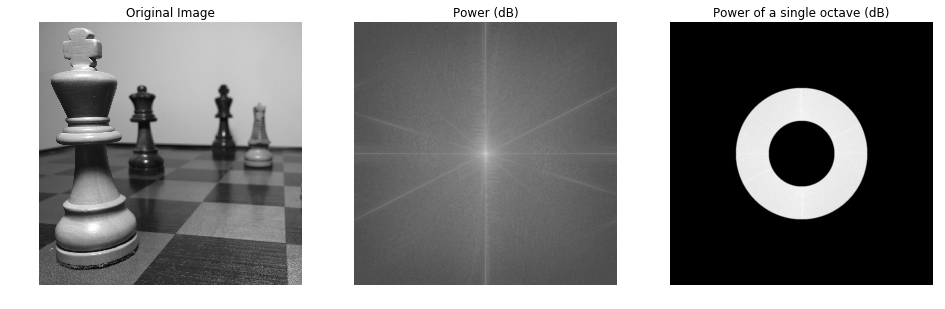

In [17]:
real_img = cv2.imread('test.png', cv2.IMREAD_GRAYSCALE)
Img = fft.fft2(real_img)
mag = np.abs(fft.fftshift(Img))
xx, yy = np.meshgrid(range(Img.shape[0]), range(Img.shape[1]))
xx -= Img.shape[1] // 2
yy -= Img.shape[0] // 2
radius = (xx**2 + yy**2)**.5
octave = np.where((128 < radius) & (radius < 256), mag, 0)

plt.figure(figsize=(16, 12))
plt.subplot(1,3,1)
plt.imshow(real_img); plt.axis('off'); plt.title('Original Image');
plt.subplot(1,3,2)
plt.imshow(np.log(mag), interpolation="bilinear"); plt.axis('off'); plt.title('Power (dB)');
plt.subplot(1,3,3)
plt.imshow(np.log(octave + 1e-13), interpolation="bilinear"); plt.axis('off'); plt.title('Power of a single octave (dB)');

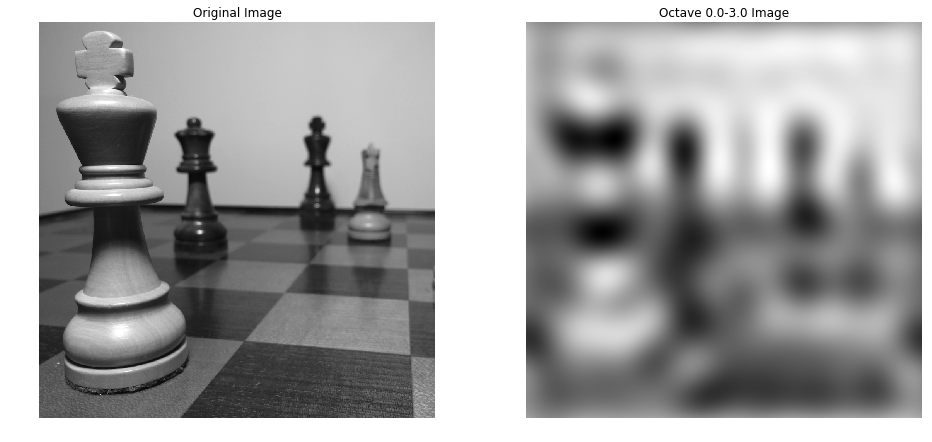

In [18]:
lo = 1
hi = 8
real_img = cv2.imread('test.png', cv2.IMREAD_GRAYSCALE)
Img = fft.fftshift(fft.fft2(real_img))
xx, yy = np.meshgrid(range(Img.shape[0]), range(Img.shape[1]))
xx -= Img.shape[1] // 2
yy -= Img.shape[0] // 2
radius = (xx**2 + yy**2)**.5
octave_img = fft.ifft2(fft.fftshift(np.where((lo <= radius) & (radius < hi), Img, 0)))

plt.figure(figsize=(16, 16))
plt.subplot(2,2,1)
plt.imshow(real_img); plt.axis('off'); plt.title('Original Image');
plt.subplot(2,2,2)
plt.imshow(octave_img.real, interpolation='bicubic'); plt.axis('off'); plt.title('Octave {}-{} Image'.format(np.log2(lo), np.log2(hi)));

## Part 3: Challenges

### 3.1 Explore the Spectrum
  - Isolate the prominent lines in the image frequency spectrum of the chess pieces and use the ifft to recover the spatial domain image using only those frequency components to visualize which features in the image are responsible for them.
  - Write a function to modify the chess pieces image to eliminate the strong horizontal & vertical components in the frequency spectrum by attenuating pixel intensity near all the image borders.
  - Apply a Gaussian filter in the pixel domain; how can you apply the same filter in the frequency domain?

### 3.2 Frequency Filtering
Write a function that takes an image and a value `k` as input and perform the following:
  - use the DFT to convert the image to the frequency domain
  - create a 2-d Gaussian of the same size as the input image with standard deviation k
  - multiply the DFT image with the 2-d Gaussian
  - convert back to the spatial domain

Plot several values of k for the same image (try to span several orders of magnitude in powers of 2). What is the overall result? Explain what you see.

### 3.3 Octave Filtering
Write a function that takes an image as input and an array `w` and perform the following:
  - use the DFT to convert the image to the frequency domain
  - starting from the highest frequencies, isolate the components of the image into separate octaves for each value in w (i.e., if there are 128 pixels and w has 4 elements, then you would separate pixels 128-65, 64-33, 32-17, and 16-0)
  - multiply each octave by the corresponding weight element in `w`
  - convert back from the frequency domain to the spatial domain

Plot several different sequences for `w` -- try an increasing/decreasing linear ramp (e.g., [1, 2, 3, 4]), a step function (e.g., [0.5, 0.5, 1.0, 1.0]), a triangle (e.g., [1, 2, 3, 2, 1]), and a gaussian. Explain what you see.

Reconstruct an image from a single octave & compare with your blending project outputs for the Gaussian & Laplacian pyramids. Explain what you see.

### 3.4 Frequency Separation
Repeat 3.2, but try doing it in the spatial domain using the Laplacian pyramid from the Blending project.
  - decompose an image into a Laplacian pyramid (covered in the blending project)
  - apply weights to each layer of the pyramid
  - recombine the layers

Try to replicate the results you obtained in 3.2

### 3.5 Other Transforms

There are other transforms similar or related to the DFT; often they incorporate both spatial and frequency components of the signal. Implement a Haar wavelet transform or a discrete cosine transform and try modifying the isolated components of the signal by linear weighting (like 3.2 and 3.3). 

Wavelet References:
  - https://en.wikipedia.org/wiki/Discrete_wavelet_transform
  - http://inside.mines.edu/~whoff/courses/EENG510/lectures/24-Wavelets.pdf
  - https://sundoc.bibliothek.uni-halle.de/diss-online/02/03H033/t4.pdf
  - http://www.cs.toronto.edu/~mangas/teaching/320/slides/CSC320L11.pdf
  - https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.signal.ricker.html#scipy.signal.ricker
  - https://www.math.cuhk.edu.hk/~lmlui/dct.pdf
  - http://www.ee.ic.ac.uk/hp/staff/dmb/courses/DSPDF/00300_Transforms.pdf